# Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the Rapper network. 
This is the outline for today:

* Visualization and qualitative analysis of the Rapper Network
* Properties of the network structure, including how attributes and other properties shape the network

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into [Section 9.4](http://networksciencebook.com/chapter/9#modularity) in the exercises below. We will also talk a little bit about degree correlations - you can read about those in [Chapter 7](http://networksciencebook.com/chapter/7)\.


![Text](https://wallpapers.com/images/high/cool-rapper-zs7xat10uqylszmy.webp "Great image choice, Jonas")


---
# Part A: Let's  visualise!

We will continue to work with the network from last week, see the lecture for [Week 4](https://nbviewer.jupyter.org/github/socialcomplexitylab/socialgraphs2021/blob/main/lectures/Week4.ipynb) for details. This is important! Actually, in order to continue with the lecture, you *need* to complete Week 4. 


*Exercise 1:* Build the right graph for visualization:

>1. Use NetworkX `DiGraph` to store the network of rappers. Remember that rappers are linked if they have a corresponding link between their Wiki contents.
>   * **Additionally**, extract the largest component - it will make our work with visualizations much easier (note: removing *isolated* nodes (with no links) does not guarantee that you are left with the largest component).
>     - *Note 1*: You probably have the right graph if you have around 730 nodes and 6000 edges.
>     - *Note 2*: For directed graphs use `weakly connected component` to extract the largest component.
>     - *Note 3*: Further analysis is done with the largest component
>2. As you build the graph, store the attributes of the nodes (their `coast`). On top of that, let's also store the `length of the content` as one of the attributes of the node (i.e. count the number of *words* you have in each rapper's page). By storing this information as nodal features, we keep all the relevant data in one place. The safe way to count words without counting symbols is to use `regex`, but simpler methods are OK.

In [6]:
import pathlib
import re
import pandas as pd

def extract_links(filename):
    try:
        with open(filename, "r", encoding="utf-8") as f:
            text = f.read()
        raw_links = re.findall("\[\[([^\[\]]*)\]\]", text)
        links = [link.split("|")[0] for link in raw_links]
        return links
    except Exception as e:
        print(f"An error occurred while processing the file {filename}")
        return None
    

def extract_name_from_filename(filename):
    return ".".join(pathlib.Path(filename).name.split(".")[:-1]).replace("%3F","?")


def count_words_in_file(filename):
    with open(filename, 'r',  encoding="utf-8") as file:
        text = file.read()
        words = re.findall(r'\b\w+\b', text)
        return len(words)


west_coast_rappers = pd.read_csv("../data/WestCoastRappers.csv")
east_coast_rappers = pd.read_csv("../data/EastCoastRappers.csv")

print(extract_links("../data/west_coast/03 Greedo.txt"))
print(extract_name_from_filename("lectures\data\west_coast\K-the-I%3F%3F%3F.txt"))
print(count_words_in_file("../data/west_coast/03 Greedo.txt"))

['Los Angeles', 'California', 'U.S.', 'West Coast hip hop', 'Trap music (hip hop)', 'Hip hop music', 'Todd Moscowitz', 'Rapping', 'Watts, Los Angeles', 'Los Angeles, California', 'Grape Street Watts Crips', 'West Los Angeles, California', 'Gardena, California', 'tympanostomy tube', 'Jordan Downs', 'Watts, Los Angeles', 'Southern hip hop', 'Todd Moscowitz', 'Smokepurpp', 'Lil Pump', 'Lil Uzi Vert', 'Desto Dubb', 'Adam Grandmaison', 'Lil Pump', 'Adam Grandmaison', 'Lil Uzi Vert', 'Blink-182', 'Travis Barker', 'Kenny Beats', 'Key Glock', 'Alamo Records', 'Sony Music Entertainment', 'Cannabis (drug)', 'methamphetamine', 'Kenny Beats', 'Mike Free', 'Nef the Pharaoh', 'Travis Barker', 'Category:Rappers from Los Angeles', 'Category:1987 births', 'Category:Living people', 'Category:People from Watts, Los Angeles', 'Category:21st-century American rappers', 'Category:West Coast hip hop musicians']
lectures\data\west_coast\K-the-I???
2061


In [39]:
import networkx as nx
from enum import Enum
from pathlib import Path

Rap_network = nx.DiGraph()
root_folder = "../data/"

class Coast(Enum):
    East_Coast = "east_coast"
    West_Coast = "west_Coast"

base_rap_names_by_coast = {
    Coast.East_Coast : set(east_coast_rappers["WikipediaPageName"]),
    Coast.West_Coast : set(west_coast_rappers["WikipediaPageName"])
}

def add_coast_rap_data(net: nx.DiGraph, coast: Coast):
    root = Path(root_folder + coast.value)
    
    for current_file in root.rglob("*.txt"):
        rap_name = extract_name_from_filename(current_file)
        net.add_node(rap_name, coast = coast, word_count = count_words_in_file(current_file))
        out_rap_names = set(extract_links(current_file)) & (base_rap_names_by_coast[Coast.East_Coast].union( base_rap_names_by_coast[Coast.West_Coast]))
        for out_rap_name in out_rap_names:
            net.add_edge(rap_name, out_rap_name)
        
add_coast_rap_data(Rap_network, Coast.East_Coast)
add_coast_rap_data(Rap_network, Coast.West_Coast)

In [40]:
print(f"Nodes before extracting giant component {len(Rap_network)}")
print(f"Edges before extracting giant component {len(Rap_network.edges())}")

Rap_network = Rap_network.subgraph(next(nx.weakly_connected_components(Rap_network)))

print(f"Nodes After extracting giant component {len(Rap_network)}")
print(f"Edges After extracting giant component {len(Rap_network.edges())}")

Nodes before extracting giant component 798
Edges before extracting giant component 5817
Nodes After extracting giant component 729
Edges After extracting giant component 5815


*Exercise 2:* Let's build a simple visualization of the network
>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in couple of the following exercises

In [41]:
Rap_nw_undirected = Rap_network.to_undirected()

>2. Use the NetworkX command `nx.draw_kamada_kawai` to draw the resulting undirected network. (You can find [background on the algorithm here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Node color should depend on the `coast` attribute (i.e. use different colors for west-coast and east-coast rappers).
>   * Set up your plot so that node-size depends on the node *degree*
>   * **Optional**: Set up you plot so that edge color depends on the `role` attribute. If an edge connects west-coast rappers, assign `color_a`, if the edge connects east-coast rappers assign `color_b`, in other cases assign `color_c` (i.e. when rapper from different coasts are connected). (Here, you get to decide on the colors.)

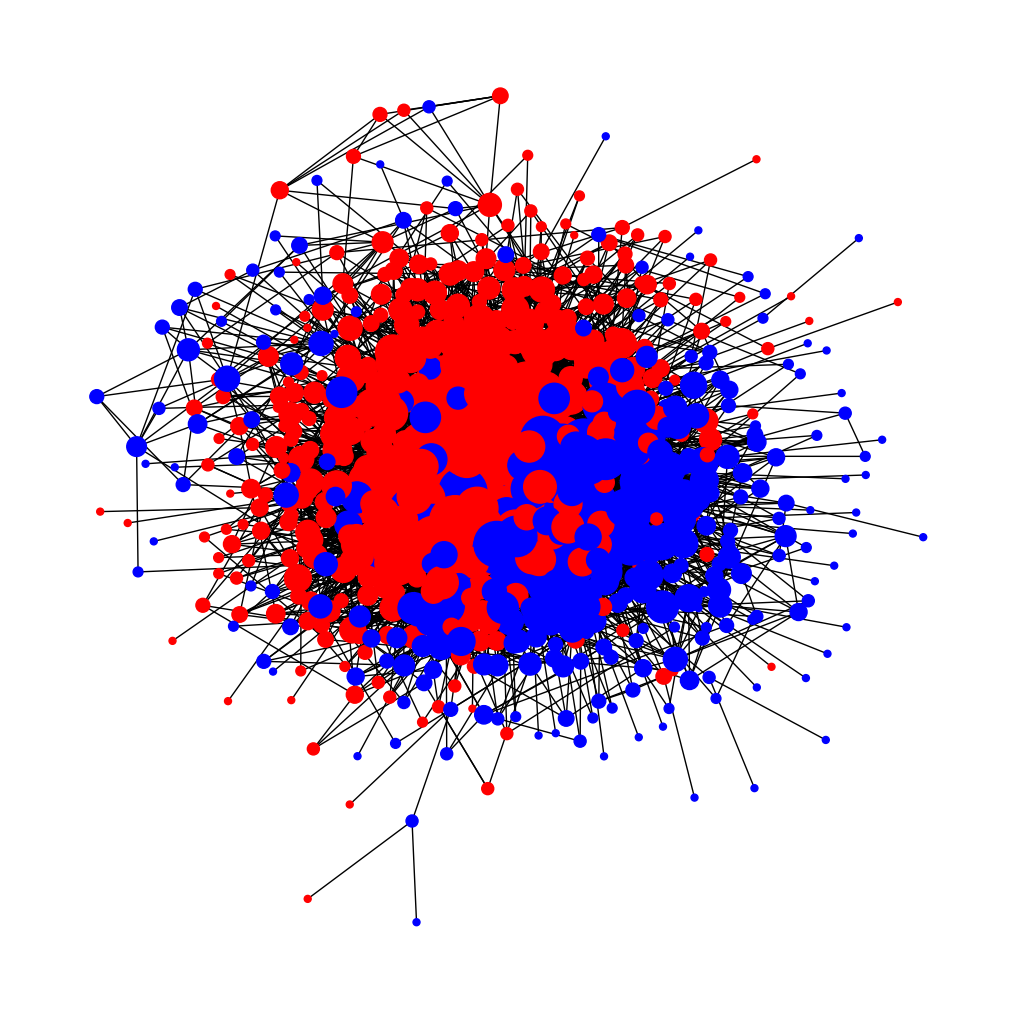

In [63]:
import networkx as nx
import matplotlib.pyplot as plt

node_sizes = [Rap_nw_undirected.degree(node) * 25 for node in Rap_nw_undirected.nodes()]

node_colors = ['blue' if Rap_nw_undirected.nodes[node].get('coast') == Coast.West_Coast else 'red' for node in Rap_nw_undirected.nodes()]

plt.figure(figsize=(10, 10))
nx.draw_kamada_kawai(
    Rap_nw_undirected,
    node_color=node_colors,
    node_size=node_sizes)

plt.show()

*Exercise 3:* From the previous plot it is more difficult to observe any specific structure in the network. We can make even better visualisations with `ForceAtlas2` package:
>1. [Force Atlas 2 algorithm](https://github.com/bhargavchippada/forceatlas2) helps to determine the positions of the nodes (see what the result looks like below).
>2.You can install the  package typing `pip install fa2` in the terminal. The [github page](https://github.com/bhargavchippada/forceatlas2) explains how to use the package to get coordinates for each node.
>   * (**Hint**: if you install force atlas and Python can't find the package it might be because you computer tries to use the system's `pip`, therefore, try installing using the Anaconda pip explicitly ( on mac you would use `~/anaconda2/bin/pip install fa2`).
> * Visualize the network using the [Networkx draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and node-coordinates from the force atlas algorithm. As in the previous Exercise:
>   * Node color should depend on the `coast` attribute (i.e. use different colors for west-coast and east-coast rappers)
>   * Node size should depend on the node *degree*
>   * **Optional**: edge color should depend on the `coast` attribute. If an edge connects west-coast rappers, assign `color_a`, if the edge connects east-coast rappers from  assign `color_b`, in other cases assign `color_c` (i.e. when connected rappers are from different coasts).
> * Play with the force atlas algorithm parameters to obtain a visualization you like. It may look similar to the one below (but not necessarily). 
> * Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?





![Text]()

![](https://github.com/SocialComplexityLab/socialgraphs2023/blob/main/files/Visualfa2Rappers.pngraw=true)

*Exercise 4*: We continue with a qualitative inspection of the rapper Wiki pages, that will help us to intepret our results. We investigate the reasons for links between rappers to exist on rapper Wiki.

>1. Consider the top 3 nodes with highest in-degree in the network. Open the corresponding Wiki pages.
>   * Consider the set of neighbours pointing towards the node found above. Look for them in the page. 
>   * What is the relation between the rappers you identified and his/her network neighbours? (e.g., do they come from the same coast, did they write songs together, etc.). You don't need to come up with a grand theory of rap music here, I just want you to think about how links come about.
>   * Repeat the exercise for the top 3 out-degree node. 
>   * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur between rappers.
>2. Are there any nodes with high out-degree and with few incoming connections? If yes, open the Wiki pages of such rappers and explain what happens?
>3. Are there any nodes with high in-degree and few outcoming connections? Again, open the Wiki pages of such rappers and explain what happens? 
>4. Do any nodes have particularly many links to rappers from the opposite coast? If yes, try and find out what is going on.

# Part B:  Advanced tools 

> **Video lecture**: [*Network measures*.](https://www.dropbox.com/scl/fi/8dal16z6z2b7lqhwq2f1j/NetworkMeasures.mp4?rlkey=c0imv3tewun2ivoxgtqrrov31&dl=0) Link: https://www.dropbox.com/scl/fi/8dal16z6z2b7lqhwq2f1j/NetworkMeasures.mp4?rlkey=c0imv3tewun2ivoxgtqrrov31&dl=0

*Exercise 1:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

>1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
>    * On top of that, calculate same statistics separately for the network that is spanned only by east-coast rappers and only by west-coast rappers. How do you interpret the results? 
>2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)*
>    * To calculate it, you can install `powerlaw` package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. What does it say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * Some long time ago, couple of scientist have analyzed the network that is spanned by the whole Wikipedia (paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A**? If not, why? 
>3. Plot a scatter plot of the the in- versus out- degree for all rappers. Comment on the relation between the two.
>4. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all rappers. What is the advantage of using a heatmap over the scatter plot?
>5. Why have we used directed graphs throughout this exercise? Could we have used an undirected graph instead?
>6. We have one more metric that we did not use. The node-attribute `content lenght`. There are two things we can investigate here.
>   * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree.
>   * Secondly, and more interestingly, it could be that famous rappers have longer texts. And that means more in-links. 
>   * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using spearman or pearson, fit a curve to the data, you decide). Once you've tested, let me know. Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words.

*Exercise 2:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise.
>1. Find the 5 most central rappers according to [degree centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html). 
>2. Find the 5 most central rappers according to [betweenness centrality](https://networkx.org/documentation/stable/auto_examples/algorithms/plot_betweenness_centrality.html?highlight=betweenness%20centrality). 
>   * Repeat Exercise A2 or A3 (depending on which visualization method you liked the most). However, this time use betweenness centrality to define the size of the node.
>   * What role do you imagine rappers with high betweenness centrality play on  Wikipedia? 
>3. Find the 5 most central rappers according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see [NetworkX documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html#networkx.algorithms.centrality.eigenvector_centrality) for details). 
>   * Repeat Exercise A2 or A3 (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>   * What role do you imagine rappers with high wikipedia graph eigenvector centrality play? 
>4. Is the undirected version of the graph assortative with respect to degree? (e.g. do high-degree rappers tend to link to other high-degree rappers, and low-degree rappers to other low-degree rappers?). Provide an interpretation of your answer.
>5. Is the undirected version of the graph assortative with respect do the `content length` nodal properties? (e.g. do rappers with long Wikipedia pages tend to link to other rappers with long Wiki pages, and *vice versa*?. Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
>6. Is the undirected version of the graph assortative with respect to Coast? (e.g. west-coast rappers tending to link to west-coast rappers, etc.). Provide an interpretation of your answer.
>7. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>   * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

*Exercise 3*: Is the coast of a rapper important for the network structure? Let us explore if and how it shapes the network (use the undirected network). 
>1. Compute the average node centrality for west-coast and east-coast rappers respectively. You are free to choose your favourite centrality measure or compare different ones. Which coast do the more central rappers have?
>2. Create a randomized version of the full graph, where the association between nodes and coast is shuffled. Compute the average centrality of west-coast and east-coast rappers for this randomized graph. 
>   * **Hint**: To create this shuffling, simply give everyone a random coast assignment (but with the same number of west-coast and east-coast rappers as in the real data). The way I usually create random lables is by using either [`random.shuffle`](https://docs.python.org/3/library/random.html#random.shuffle) or [`numpy.random.permutation`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html).
>3. Repeat the shuffling process above 1000 times (at least) and plot two histograms, each histogram with the 1000 corresponding average values of centrality obtained for west-coast and east-coast rappers in the shuffeled netowrks.
>4. Compare the value you have obtained in the real graph, with the randomized cases. Are rappers from one coast more central in the network (on average)?
>5. Think about your results, what could be possible explanations for what you observe?

The shuffling procedure you just carried out is often called a _permutation test_. It is a super powerful tool that we use all the time. Once you start to think about it, you can answer many questions of the type "Is [property] higher/lower in this network than one might have expected by chance?" with permutation tests.